In [1]:
import os
import sys
import cv2
import torch
import random
import warnings
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
# import pydicom as pdcm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import KFold
import random
import copy
import nibabel as nib 
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
all_list = []
for root, dirs, files in os.walk('./AD/'):
    for file in files:
        file_path = os.path.join(root, file)
        all_list.append(file_path)

for root, dirs, files in os.walk('./CN/'):
    for file in files:
        file_path = os.path.join(root, file)
        all_list.append(file_path)
all_list = list(filter(lambda x: '.DS_Store' not in x, all_list))
# all_list.remove('./CN/011_S_0016/ADNI_011_S_0016_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061206170814835_S13160_I31928.nii')
# all_list.remove('./CN/013_S_0502/ADNI_013_S_0502_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070926112008188_S27531_I75291.nii')

In [3]:
means, stdevs = [], []
all_data = np.zeros((100, 192, 192, 160))
for idx, val in enumerate(all_list):
    img = nib.load(val) #读取nii
    img_fdata = img.get_fdata()
    if img_fdata.shape[2] > 160:
        img_fdata = img_fdata[:, :, 4:164]
    img_fdata = cv2.resize(img_fdata, (192, 192))
    all_data[idx] = img_fdata

means = np.mean(all_data, axis = (0, 1, 2))
stds = np.std(all_data, axis = (0, 1, 2))

In [4]:
class MRIdata(Dataset):
    def __init__(self, path_list, transform = None):
        self.path_list = path_list
        self.transform = transform


    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, index):
        
        img = nib.load(self.path_list[index]) #读取nii
        img_fdata = img.get_fdata()
        if img_fdata.shape[2] > 160:
            img_fdata = img_fdata[:, :, 4:164]
        img_fdata = cv2.resize(img_fdata, (192, 192))
        
#         print(img_fdata.shape, type(img_fdata))

#         inp_data = read_dicom_img(self.train_dir, str(self.data['BraTS21ID'][index]))
        inp_data = self.transform(img_fdata[:])
        if self.path_list[index].split('/')[1] == 'AD':
            label = torch.tensor([0, 1], dtype = torch.float)
        else:
            label = torch.tensor([1, 0], dtype = torch.float)
        
#         print(self.path_list[index].split('/')[1])
        return inp_data.float(), label#.unsqueeze(1), label

In [5]:
transforms = T.Compose([T.ToTensor(), T.Normalize(means, stds)])


random.shuffle(all_list)

train_dataset = MRIdata(all_list[:80], transform = transforms)
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 16)

test_dataset = MRIdata(all_list[80:], transform = transforms)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 32)

In [6]:
# for indx, (data, label) in enumerate(train_loader, 0):
#     inputs, labels = data.to(device), label.to(device)
#     break

In [7]:
class MRINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(self.conv_layer(in_chan = 160, out_chan = 128),
                                  self.conv_layer(in_chan = 128, out_chan = 128),
                                  self.conv_layer(in_chan = 128, out_chan = 256))
        
        self.fc = nn.Sequential(nn.Linear(123904, 512),
                                nn.Dropout(p = 0.15),
                                nn.Linear(512, 256),
                               nn.Linear(256, 2))
        self.sigmoid = nn.Sigmoid()
    
    def conv_layer(self, in_chan, out_chan):
        conv_layer = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=(3, 3), padding = 0),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(out_chan))
        
        return conv_layer    
           
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)    
        return self.sigmoid(out)

In [8]:
net = MRINet().to(device)

LRate = 0.0001
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(net.parameters(), lr = LRate)
EPOCHS = 100
best_acc = 0


best_model = copy.deepcopy(net)  # Will work
    
for epoch in range(EPOCHS):
    total_loss = 0.0
    count = 0
    net.train()
    for indx, (data, label) in enumerate(train_loader, 0):
        inputs, labels = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)#.squeeze(1)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        total_loss += loss.detach().item()
        optimizer.step()
        
        count += 1
    
    print(f"Epoch:{epoch}/{EPOCHS} - train Loss:{total_loss/count}")
    
    net.eval()
    total_loss = 0.0
    count = 0
    correct = 0
    total = 0
    
    for indx, (data, label) in enumerate(test_loader, 0):
        with torch.no_grad():
            inputs, labels = data.to(device), label.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            total_loss += loss.detach().item()
            
            _, predicted = torch.max(outputs, 1)
            _, labelss = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labelss).sum().item()
            
            count += 1
    print(f"Epoch:{epoch}/{EPOCHS} - test Loss:{total_loss/count}")

    print(f'Accuracy of the network on the 20 test images: {100 * correct / total} %')
    
    if best_acc < correct / total:
        print('acc {} -> {} improve saving ....'.format(best_acc, correct / total))
        best_model = copy.deepcopy(net)  
        
        best_acc = correct / total
    print('-----------------------')

print("Training Complete")    
torch.save(best_model, './best_model_cnn2.pt')

Epoch:0/100 - train Loss:0.7454449534416199
Epoch:0/100 - test Loss:0.7363566756248474
Accuracy of the network on the 20 test images: 40.0 %
acc 0 -> 0.4 improve saving ....
-----------------------
Epoch:1/100 - train Loss:0.6675355434417725
Epoch:1/100 - test Loss:0.6973126530647278
Accuracy of the network on the 20 test images: 45.0 %
acc 0.4 -> 0.45 improve saving ....
-----------------------
Epoch:2/100 - train Loss:0.6612977981567383
Epoch:2/100 - test Loss:0.6913159489631653
Accuracy of the network on the 20 test images: 45.0 %
-----------------------
Epoch:3/100 - train Loss:0.5716818809509278
Epoch:3/100 - test Loss:0.7313534617424011
Accuracy of the network on the 20 test images: 50.0 %
acc 0.45 -> 0.5 improve saving ....
-----------------------
Epoch:4/100 - train Loss:0.5539215624332428
Epoch:4/100 - test Loss:0.6392772793769836
Accuracy of the network on the 20 test images: 55.0 %
acc 0.5 -> 0.55 improve saving ....
-----------------------
Epoch:5/100 - train Loss:0.5915553

Epoch:48/100 - test Loss:0.7744233012199402
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:49/100 - train Loss:0.3257618248462677
Epoch:49/100 - test Loss:0.7742913365364075
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:50/100 - train Loss:0.3257619023323059
Epoch:50/100 - test Loss:0.774257242679596
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:51/100 - train Loss:0.3257622003555298
Epoch:51/100 - test Loss:0.7739885449409485
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:52/100 - train Loss:0.32576239109039307
Epoch:52/100 - test Loss:0.7765567898750305
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:53/100 - train Loss:0.3257624924182892
Epoch:53/100 - test Loss:0.7772566676139832
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:54/100 - train Loss:0.325761938095092

Epoch:97/100 - test Loss:0.7752560973167419
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:98/100 - train Loss:0.32576186060905454
Epoch:98/100 - test Loss:0.7749426960945129
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Epoch:99/100 - train Loss:0.32576189637184144
Epoch:99/100 - test Loss:0.7754369378089905
Accuracy of the network on the 20 test images: 55.0 %
-----------------------
Training Complete


In [9]:
best_acc

0.6

In [ ]:
# _, predicted = torch.max(outputs.data, 1)
# total += labels.size(0)
# correct += (predicted == labels).sum().item()

In [10]:
best_acc

0.6

In [9]:
torch.save(best_model, './best_model.pt')

In [12]:
net = torch.load('./best_model_cnn2.pt').to(device)
net.eval()
correct = 0
total = 0
for indx, (data, label) in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, labels = data.to(device), label.to(device)
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labelss = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == labelss).sum().item()
print(f'Accuracy of the network on the 20 test images: {100 * correct / total} %')
# # outputs = torch.where(outputs > 0.00001, 1, 0)

Accuracy of the network on the 20 test images: 60.0 %


In [13]:
predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:1')

In [14]:
labelss

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1],
       device='cuda:1')

In [15]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(labelss.int().cpu().numpy(), predicted.cpu().numpy()).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
# from sklearn.metrics import recall_score
# recall_score(labels.int().cpu().numpy(), outputs.cpu().numpy(), pos_label = 0)

specificity:  1.0
sensitivity:  0.1111111111111111


In [16]:
net.train()

for indx, (data, label) in enumerate(test_loader, 0):
    inputs, labels = data.to(device), label.to(device)
    inputs.requires_grad = True
    break
outputs = net(inputs).sum() ** 2
outputs.backward()
imgs = (inputs * inputs.grad.data).cpu().detach().numpy()

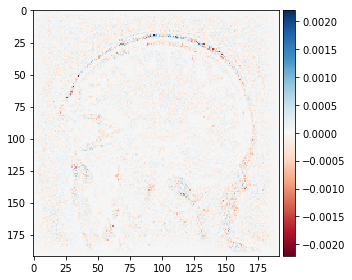

In [18]:
from skimage import io
io.imshow(imgs[5, 100])

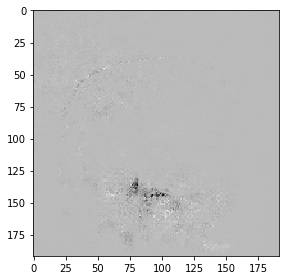

In [36]:
from skimage import io
from skimage import io, transform, img_as_float 
#img_as_float将图像转化为0-1的浮点数
import numpy as np
def int_to_float(image):
#     image = io.imread(f)   #读取图像为整型， [0-255]
#     image = img_as_float(image)  #变为浮点型[0-1]。
    image = (image - image.min()) * (1 / (image.max() - image.min()))  #比例缩放的归一化
#     image = transform.resize(image, (256, 256))  #图像缩放大小
    return image

io.imshow(int_to_float(imgs[5, 110, 0]))

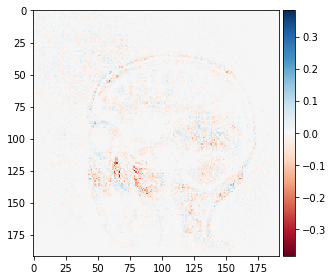

In [42]:
io.imshow(imgs[5, 110, 0] * 1000)

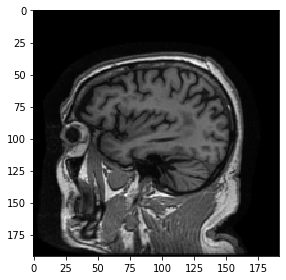

In [30]:
io.imshow(int_to_float(inputs.cpu().detach().numpy()[10, 110, 0]))